In [1]:
#CW
import torch
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.autograd.gradcheck import zero_gradients
import torch.utils.data.dataloader as Data
import torch.nn as nn
from torchvision import models
import numpy as np
import cv2
from tools import show_images_diff

In [2]:
#获取计算设备 默认是CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#图像加载以及预处理
image_path="../picture/cropped_panda.jpg"
orig = cv2.imread(image_path)[..., ::-1]
orig = cv2.resize(orig, (224, 224))
img = orig.copy().astype(np.float32)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img /= 255.0
img = (img - mean) / std
img = img.transpose(2, 0, 1)

img=np.expand_dims(img, axis=0)

print(img.shape)

#使用预测模式 主要影响droupout和BN层的行为
model = models.alexnet(pretrained=True).to(device).eval()


(1, 3, 224, 224)


In [3]:
#adam的最大迭代次数 论文中建议10000次 测试阶段1000也可以 1000次可以完成95%的优化工作
max_iterations=1000
#adam学习速率
learning_rate=0.01
#二分查找最大次数
binary_search_steps=10
#c的初始值
initial_const=1
confidence=initial_const

#k值
k=40

#像素值区间
boxmin = -3.0
boxmax = 3.0

#类别数 pytorch的实现里面是1000
num_labels=1000

#攻击目标标签 必须使用one hot编码
target_label=288
tlab=Variable(torch.from_numpy(np.eye(num_labels)[target_label]).to(device).float())


print()

shape = (1,3,224,224)


In [4]:


#c的初始化边界
lower_bound = 0
c=initial_const
upper_bound = 1e10

# the best l2, score, and image attack
o_bestl2 = 1e10
o_bestscore = -1
o_bestattack = [np.zeros(shape)]



In [5]:
import torch.nn.functional as F

# the resulting image, tanh'd to keep bounded from boxmin to boxmax
boxmul = (boxmax - boxmin) / 2.
boxplus = (boxmin + boxmax) / 2.

for outer_step in range(binary_search_steps):
    print("o_bestl2={} confidence={}".format(o_bestl2,confidence)  )
    
    #把原始图像转换成图像数据和扰动的形态
    timg = Variable(torch.from_numpy(np.arctanh((img - boxplus) / boxmul * 0.999999)).to(device).float())
    modifier=Variable(torch.zeros_like(timg).to(device).float())
    

    #设置为不保存梯度值 自然也无法修改
    #for param in model.parameters():
    #    param.requires_grad = False
        
    #图像数据的扰动量梯度可以获取
    modifier.requires_grad = True
    

    #定义优化器 仅优化modifier
    optimizer = torch.optim.Adam([modifier],lr=learning_rate)
    
    for iteration in range(1,max_iterations+1):
        optimizer.zero_grad()
        
        #定义新输入
        newimg = torch.tanh(modifier + timg) * boxmul + boxplus
      
        output=model(newimg)
             
        #定义cw中的损失函数
        
        #l2范数
        #l2dist = tf.reduce_sum(tf.square(newimg-(tf.tanh(timg) * boxmul + boxplus)),[1,2,3])
        #loss2 = tf.reduce_sum(l2dist)
        loss2=torch.dist(newimg,(torch.tanh(timg) * boxmul + boxplus),p=2)
        
        """
        # compute the probability of the label class versus the maximum other
            real = tf.reduce_sum((tlab)*output,1)
            # 论文中的开源实现 other = tf.reduce_max((1-tlab)*output - (tlab*10000),1)
            other = tf.reduce_max((1-tlab)*output)
            loss1 = tf.maximum(0.0, other-real+k)
            loss1 = tf.reduce_sum(const*loss1)
        """
               
        real=torch.max(output*tlab)
        other=torch.max((1-tlab)*output)  
        loss1=other-real+k   
        loss1=torch.clamp(loss1,min=0)
             
        loss1=confidence*loss1
           
        loss=loss1+loss2
               
        loss.backward(retain_graph=True)

        optimizer.step()
              
        l2=loss2
        
        sc=output.data.cpu().numpy()
        
        
        #输出的是概率
        pro=F.softmax(model(newimg),dim=1)[0].data.cpu().numpy()[target_label]
         
        # print out the losses every 10%
        if iteration%(max_iterations//10) == 0:
            print("iteration={} loss={} loss1={} loss2={} pro={}".format(iteration,loss,loss1,loss2,pro))
              
        if (l2 < o_bestl2) and (np.argmax(sc) == target_label  ) and ( pro > 0.8  ):
        #if (l2 < o_bestl2) and (np.argmax(sc) == target_label  ) :
            print("attack success l2={} target_label={} pro={}".format(l2,target_label,pro))
            o_bestl2 = l2
            o_bestscore = np.argmax(sc)
            o_bestattack = newimg.data.cpu().numpy()
            
    confidence_old=-1       
    if (o_bestscore == target_label) and o_bestscore != -1:
        #攻击成功 减小c
        upper_bound = min(upper_bound,confidence)
        if upper_bound < 1e9:
                print()
                confidence_old=confidence
                confidence = (lower_bound + upper_bound)/2
    else:
        lower_bound = max(lower_bound,confidence)
        confidence_old=confidence
        if upper_bound < 1e9:
                confidence = (lower_bound + upper_bound)/2
        else:
                confidence *= 10
                
    print("outer_step={} confidence {}->{}".format(outer_step,confidence_old,confidence))

o_bestl2=10000000000.0 confidence=1
attack success l2=12.031506538391113 target_label=288 pro=0.8148753643035889
attack success l2=11.90378475189209 target_label=288 pro=0.9941805601119995
attack success l2=11.758527755737305 target_label=288 pro=0.9945294260978699
attack success l2=11.716538429260254 target_label=288 pro=0.9931824803352356
attack success l2=11.71518611907959 target_label=288 pro=0.9942597150802612
attack success l2=11.686195373535156 target_label=288 pro=0.9948215484619141
attack success l2=11.610492706298828 target_label=288 pro=0.9953668117523193
attack success l2=11.564008712768555 target_label=288 pro=0.995058536529541
attack success l2=11.526888847351074 target_label=288 pro=0.9968855977058411
attack success l2=11.435786247253418 target_label=288 pro=0.9952104687690735
iteration=100 loss=45.293521881103516 loss1=32.68703079223633 loss2=12.606492042541504 pro=0.9980906844139099
iteration=200 loss=45.221317291259766 loss1=31.565427780151367 loss2=13.655889511108398

iteration=200 loss=1.171724796295166 loss1=0.8178942203521729 loss2=0.35383057594299316 pro=3.980791007052176e-06
iteration=300 loss=1.085099220275879 loss1=0.8184861540794373 loss2=0.26661309599876404 pro=3.8519369809364434e-06
iteration=400 loss=1.0997462272644043 loss1=0.8208172917366028 loss2=0.2789289057254791 pro=3.3400738175259903e-06
iteration=500 loss=1.1355596780776978 loss1=0.8194049596786499 loss2=0.31615471839904785 pro=3.6474159514909843e-06
iteration=600 loss=1.121152639389038 loss1=0.8172410726547241 loss2=0.30391162633895874 pro=4.139608336117817e-06
iteration=700 loss=1.0736150741577148 loss1=0.8219298124313354 loss2=0.25168532133102417 pro=3.12341217068024e-06
iteration=800 loss=1.257462501525879 loss1=0.8135678172111511 loss2=0.44389471411705017 pro=5.177354069019202e-06
iteration=900 loss=1.0496515035629272 loss1=0.8202581405639648 loss2=0.22939331829547882 pro=3.457635102677159e-06
iteration=1000 loss=1.060261607170105 loss1=0.819364070892334 loss2=0.2408975213766

In [6]:
print(o_bestattack.shape)
print(img.shape)

(1, 3, 224, 224)
(1, 3, 224, 224)


In [7]:
adv=o_bestattack[0]
print(adv.shape)
adv = adv.transpose(1, 2, 0)
adv = (adv * std) + mean
adv = adv * 256.0
adv = np.clip(adv, 0, 255).astype(np.uint8)


(3, 224, 224)


In [8]:
def infer_img(img,t=0):
    import torch.nn.functional as F
    
    img=img.astype(np.float32)
    
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    img /= 255.0
    img = (img - mean) / std
    img = img.transpose(2, 0, 1)

    img=np.expand_dims(img, axis=0)

    img = Variable(torch.from_numpy(img).to(device).float())
    #print(img.shape)

    #使用预测模式 主要影响droupout和BN层的行为
    model = models.alexnet(pretrained=True).to(device).eval()
      
    output=F.softmax(model(img),dim=1)
        
    label=np.argmax(output.data.cpu().numpy())
    
    pro=output.data.cpu().numpy()[0][label]
    
    #当t不为0时返回指定类别的概率
    if t != 0:
        pro=output.data.cpu().numpy()[0][t]
        
    return pro

In [9]:
print(infer_img(orig))
print(infer_img(orig,t=288))
print(infer_img(orig,t=388))
print(infer_img(adv))
print(infer_img(adv,t=288))
print(infer_img(adv,t=388))

0.9270878
3.1756701e-06
0.9270878
0.81074756
0.81074756
0.001160161


std=0.01 adv_pro[388]=0.025568192824721336 original_pro[388]=0.9754388332366943
std=0.02 adv_pro[388]=0.5575308799743652 original_pro[388]=0.9896204471588135
std=0.03 adv_pro[388]=0.9478294253349304 original_pro[388]=0.9819725155830383
std=0.04 adv_pro[388]=0.9307391047477722 original_pro[388]=0.949892520904541
std=0.05 adv_pro[388]=0.891160786151886 original_pro[388]=0.9730779528617859
std=0.060000000000000005 adv_pro[388]=0.8505075573921204 original_pro[388]=0.9556888937950134
std=0.06999999999999999 adv_pro[388]=0.8213750123977661 original_pro[388]=0.9179550409317017
std=0.08 adv_pro[388]=0.799411416053772 original_pro[388]=0.3636905252933502
std=0.09 adv_pro[388]=0.2839242219924927 original_pro[388]=0.6279651522636414
std=0.09999999999999999 adv_pro[388]=0.2004043161869049 original_pro[388]=0.3246232271194458
std=0.11 adv_pro[388]=0.23116928339004517 original_pro[388]=0.32653653621673584
std=0.12 adv_pro[388]=0.2157985121011734 original_pro[388]=0.22313973307609558
std=0.13 adv_pro

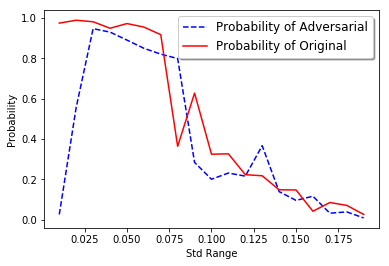

In [10]:
import matplotlib.pyplot as plt
import skimage
#综合分析高斯对 对抗样本和正常图片分类的影响
std_range = np.arange(0.01,0.20,0.01)
original_pro = []
adv_pro = []

for i in std_range:
    
    gaussian_adv_img=skimage.util.random_noise(adv.copy(), mode="gaussian", seed=None, clip=True,mean=0,var=i**2)
    pro_388=infer_img(gaussian_adv_img.copy()*256.0,388) 
    adv_pro+= [pro_388]
    
    gaussian_img=skimage.util.random_noise(orig.copy(), mode="gaussian", seed=None, clip=True,mean=0,var=i**2)
    pro=infer_img(gaussian_img.copy()*256.0,388)
    original_pro += [pro]
            
    print("std={} adv_pro[388]={} original_pro[388]={}".format(i,pro_388,pro))


fig, ax = plt.subplots()
ax.plot(np.array(std_range), np.array(adv_pro), 'b--', label='Probability of Adversarial')
ax.plot(np.array(std_range), np.array(original_pro), 'r', label='Probability of Original')

legend = ax.legend(loc='best', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#FFFFFF')

plt.xlabel('Std Range')
plt.ylabel('Probability')
plt.show()

std=0.001 pro[388]=0.0011931571643799543 pro[288]=0.8093545436859131
std=0.002 pro[388]=0.0014028012519702315 pro[288]=0.8041859269142151
std=0.003 pro[388]=0.0016880686162039638 pro[288]=0.7979101538658142
std=0.004 pro[388]=0.0019210694590583444 pro[288]=0.7772931456565857
std=0.005 pro[388]=0.00316422781907022 pro[288]=0.7415587306022644
std=0.006 pro[388]=0.004116940312087536 pro[288]=0.6904603242874146
std=0.007 pro[388]=0.007921879179775715 pro[288]=0.6534750461578369
std=0.008 pro[388]=0.010202541016042233 pro[288]=0.5931445360183716
std=0.009000000000000001 pro[388]=0.011499655432999134 pro[288]=0.5592191815376282
std=0.010000000000000002 pro[388]=0.02754412218928337 pro[288]=0.4381450116634369
std=0.011 pro[388]=0.04669402539730072 pro[288]=0.34992244839668274
std=0.012 pro[388]=0.08895397186279297 pro[288]=0.2594844400882721
std=0.013000000000000001 pro[388]=0.13552725315093994 pro[288]=0.2109202891588211
std=0.014000000000000002 pro[388]=0.2295933961868286 pro[288]=0.1102449

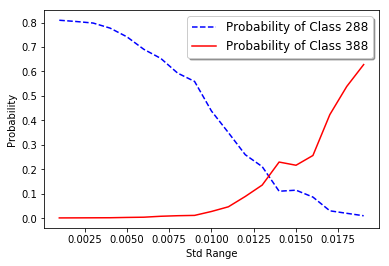

In [11]:
#验证高斯噪声 对抗样本的影响
import skimage
std_range = np.arange(0.001,0.020,0.001)
adv_288_pro = []
adv_388_pro = []

for i in std_range:
    
    gaussian_img=skimage.util.random_noise(adv.copy(), mode="gaussian", seed=None, clip=True,mean=0,var=i**2)
    
    pro_388=infer_img(gaussian_img.copy()*256.0,388)
    pro_288=infer_img(gaussian_img.copy()*256.0,288)
    print("std={} pro[388]={} pro[288]={}".format(i,pro_388,pro_288))
    adv_288_pro += [pro_288]
    adv_388_pro += [pro_388]

fig, ax = plt.subplots()
ax.plot(np.array(std_range), np.array(adv_288_pro), 'b--', label='Probability of Class 288')
ax.plot(np.array(std_range), np.array(adv_388_pro), 'r', label='Probability of Class 388')

legend = ax.legend(loc='best', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#FFFFFF')

plt.xlabel('Std Range')
plt.ylabel('Probability')
plt.show()

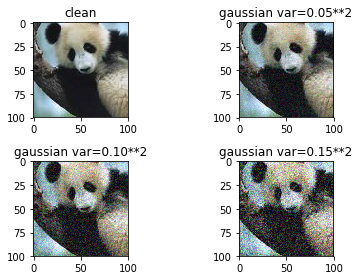

In [12]:
#演示增加高斯噪声
import numpy as np
import cv2
import skimage
from scipy import * 
from matplotlib import pyplot as plt 
img=cv2.imread("../picture/cropped_panda.jpg")
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img1=img.copy()
img2=img.copy()

img2=skimage.util.random_noise(img2, mode="gaussian",  seed=None, clip=True,mean=0,var=0.05**2)

plt.subplot(221)
plt.imshow(img1) 
plt.title("clean")

plt.subplot(222)
plt.imshow(img2) 
plt.title("gaussian var=0.05**2")

img3=img.copy()
img4=img.copy()

img3=skimage.util.random_noise(img3, mode="gaussian",  seed=None, clip=True,mean=0,var=0.10**2)
img4=skimage.util.random_noise(img4, mode="gaussian",  seed=None, clip=True,mean=0,var=0.15**2)

plt.subplot(223)
plt.imshow(img3) 
plt.title("gaussian var=0.10**2")

plt.subplot(224)
plt.imshow(img4) 
plt.title("gaussian var=0.15**2")


plt.tight_layout()

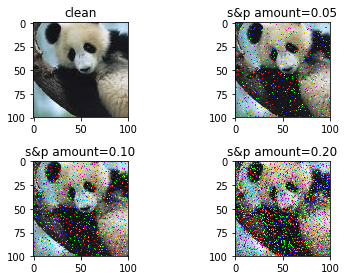

In [13]:
#演示增加椒盐噪声
import numpy as np
import cv2
import skimage
from scipy import * 
from matplotlib import pyplot as plt 
img=cv2.imread("../picture/cropped_panda.jpg")
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img1=img.copy()
img2=img.copy()

img2=skimage.util.random_noise(img2, mode="s&p",  seed=None, clip=True,amount=0.05)

plt.subplot(221)
plt.imshow(img1) 
plt.title("clean")

plt.subplot(222)
plt.imshow(img2) 
plt.title("s&p amount=0.05")

img3=img.copy()
img4=img.copy()

img3=skimage.util.random_noise(img3, mode="s&p",  seed=None, clip=True,amount=0.10)
img4=skimage.util.random_noise(img4, mode="s&p",  seed=None, clip=True,amount=0.20)

plt.subplot(223)
plt.imshow(img3) 
plt.title("s&p amount=0.10")

plt.subplot(224)
plt.imshow(img4) 
plt.title("s&p amount=0.20")


plt.tight_layout()

amount=0.001 adv_pro[388]=0.1618199348449707 original_pro[388]=0.9676821231842041
amount=0.002 adv_pro[388]=0.7275665998458862 original_pro[388]=0.9490123987197876
amount=0.003 adv_pro[388]=0.6580780744552612 original_pro[388]=0.9351553320884705
amount=0.004 adv_pro[388]=0.738917350769043 original_pro[388]=0.92970210313797
amount=0.005 adv_pro[388]=0.7523161172866821 original_pro[388]=0.9444864988327026
amount=0.006 adv_pro[388]=0.8841724395751953 original_pro[388]=0.9766266942024231
amount=0.007 adv_pro[388]=0.8150253295898438 original_pro[388]=0.9623963236808777
amount=0.008 adv_pro[388]=0.933829665184021 original_pro[388]=0.8594310283660889
amount=0.009000000000000001 adv_pro[388]=0.5617998838424683 original_pro[388]=0.8841466307640076
amount=0.010000000000000002 adv_pro[388]=0.6833334565162659 original_pro[388]=0.8684905767440796
amount=0.011 adv_pro[388]=0.8387390971183777 original_pro[388]=0.8011199831962585
amount=0.012 adv_pro[388]=0.8910350203514099 original_pro[388]=0.6488232

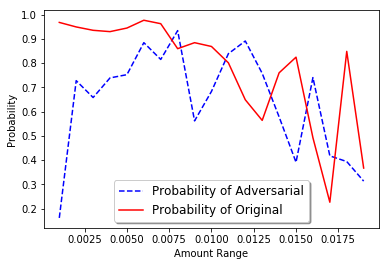

In [16]:
import matplotlib.pyplot as plt
import skimage
#综合分析椒盐噪声对 对抗样本和正常图片分类的影响
std_range = np.arange(0.001,0.02,0.001)
original_pro = []
adv_pro = []

for i in std_range:
    
    sp_adv_img=skimage.util.random_noise(adv.copy(), mode="s&p", seed=None, clip=True,amount=i)
    pro_388=infer_img(sp_adv_img.copy()*256.0,388) 
    adv_pro+= [pro_388]
    
    sp_img=skimage.util.random_noise(orig.copy(), mode="s&p", seed=None, clip=True,amount=i)
    pro=infer_img(sp_img.copy()*256.0,388)
    original_pro += [pro]
            
    print("amount={} adv_pro[388]={} original_pro[388]={}".format(i,pro_388,pro))


fig, ax = plt.subplots()
ax.plot(np.array(std_range), np.array(adv_pro), 'b--', label='Probability of Adversarial')
ax.plot(np.array(std_range), np.array(original_pro), 'r', label='Probability of Original')

legend = ax.legend(loc='best', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#FFFFFF')

plt.xlabel('Amount Range')
plt.ylabel('Probability')
plt.show()

std=0.001 pro[388]=0.3334718942642212 pro[288]=0.024634912610054016
std=0.002 pro[388]=0.549170196056366 pro[288]=0.003624740755185485
std=0.003 pro[388]=0.8475828766822815 pro[288]=0.00032185635063797235
std=0.004 pro[388]=0.8774625062942505 pro[288]=0.00023722276091575623
std=0.005 pro[388]=0.7619825601577759 pro[288]=0.0002151287189917639
std=0.006 pro[388]=0.615450382232666 pro[288]=0.0006208967533893883
std=0.007 pro[388]=0.8287277817726135 pro[288]=0.00010628660675138235
std=0.008 pro[388]=0.6143295764923096 pro[288]=0.000552751065697521
std=0.009000000000000001 pro[388]=0.8237481713294983 pro[288]=0.00011446527059888467
std=0.010000000000000002 pro[388]=0.45212462544441223 pro[288]=0.0006308644078671932
std=0.011 pro[388]=0.7742503881454468 pro[288]=0.0005989844794385135
std=0.012 pro[388]=0.5022258162498474 pro[288]=0.00045320444041863084
std=0.013000000000000001 pro[388]=0.4439176023006439 pro[288]=0.00043717975495383143
std=0.014000000000000002 pro[388]=0.5366431474685669 pro

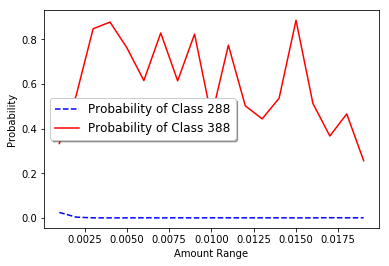

In [17]:
#验证椒盐噪声 对抗样本的影响
import skimage
std_range = np.arange(0.001,0.02,0.001)
adv_288_pro = []
adv_388_pro = []

for i in std_range:
    
    sp_img=skimage.util.random_noise(adv.copy(), mode="s&p", seed=None, clip=True,amount=i)
    
    pro_388=infer_img(sp_img.copy()*256.0,388)
    pro_288=infer_img(sp_img.copy()*256.0,288)
    print("std={} pro[388]={} pro[288]={}".format(i,pro_388,pro_288))
    adv_288_pro += [pro_288]
    adv_388_pro += [pro_388]

fig, ax = plt.subplots()
ax.plot(np.array(std_range), np.array(adv_288_pro), 'b--', label='Probability of Class 288')
ax.plot(np.array(std_range), np.array(adv_388_pro), 'r', label='Probability of Class 388')

legend = ax.legend(loc='best', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#FFFFFF')

plt.xlabel('Amount Range')
plt.ylabel('Probability')
plt.show()